In [107]:
# 1. import module

import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from pycaret.regression import *

from sklearn.model_selection import train_test_split 
from sklearn import metrics
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.max_seq_items = None


In [87]:
# 2. data import

raw_data = pd.read_csv("./Data_2021_10_14_v1 (N98923)/Data.csv")


# 학습할 파라미터를 제외한 나머지 아웃풋 삭제
output = ["Lmt","Lmr","Llt","Llr","k","Lt","Lr","Lm","Rt","Rr","I1","I2","Zt","Zr","Zm","copperloss_tx","copperloss_rx"]
parameter = "Llt"
output.remove(parameter)

for pam in output :
    raw_data = raw_data.drop(columns=pam)

# NaN 데이터 삭제
raw_data = raw_data.dropna()

display(raw_data.head())

,N1,N2,d1,d2,freq,move_tx,move_rx,offset_tx,offset_rx,per,space1,space2,space3,space4,l1,l2,h1,w1,Llt
0,8,8,6.0,9.7,49000.0,2,5,7,-9,1480,1,23,3,55,19,41,166,24,6.704324
1,8,8,11.7,10.7,49000.0,6,4,18,-5,1160,5,47,3,31,31,72,251,248,13.703235
2,8,8,9.0,5.4,49000.0,4,1,9,-18,4192,5,31,7,28,33,40,191,212,19.559244
3,8,8,9.5,4.2,49000.0,6,3,14,-7,3419,1,21,6,38,15,30,185,221,16.173505
4,11,11,7.5,10.3,58000.0,1,2,13,-17,4445,7,50,6,46,16,69,207,241,35.181363


In [88]:
# 3. data info check

print(raw_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98920 entries, 0 to 98922
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   N1         98920 non-null  int64  
 1   N2         98920 non-null  int64  
 2   d1         98920 non-null  float64
 3   d2         98920 non-null  float64
 4   freq       98920 non-null  float64
 5   move_tx    98920 non-null  int64  
 6   move_rx    98920 non-null  int64  
 7   offset_tx  98920 non-null  int64  
 8   offset_rx  98920 non-null  int64  
 9   per        98920 non-null  int64  
 10  space1     98920 non-null  int64  
 11  space2     98920 non-null  int64  
 12  space3     98920 non-null  int64  
 13  space4     98920 non-null  int64  
 14  l1         98920 non-null  int64  
 15  l2         98920 non-null  int64  
 16  h1         98920 non-null  int64  
 17  w1         98920 non-null  int64  
 18  Llt        98920 non-null  float64
dtypes: float64(4), int64(15)
memory usage: 15.1 MB

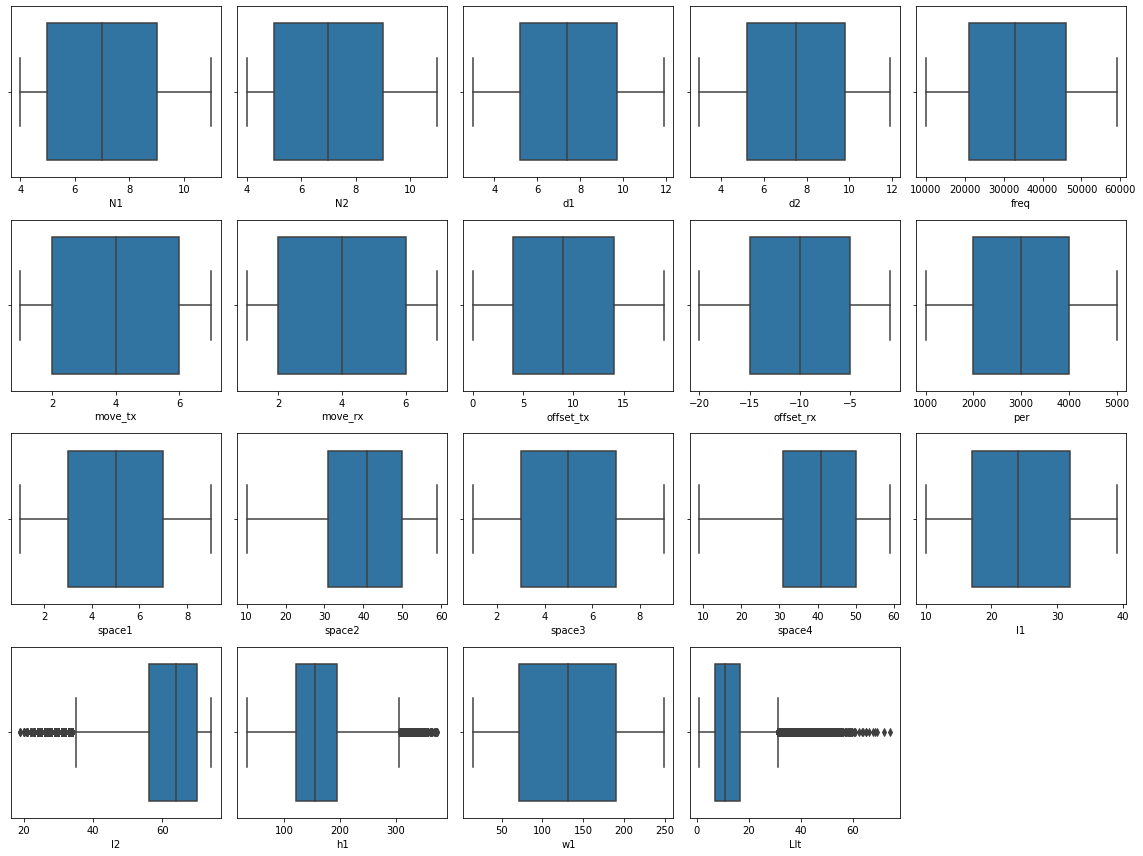

In [89]:
# 4. check outlier

plt.figure(figsize=(16, 12))
for i, colName in enumerate(list(raw_data.columns)) :
    plt.subplot(4, 5, i+1)
    sns.boxplot(x=raw_data.loc[:, colName])
plt.tight_layout()
plt.show()

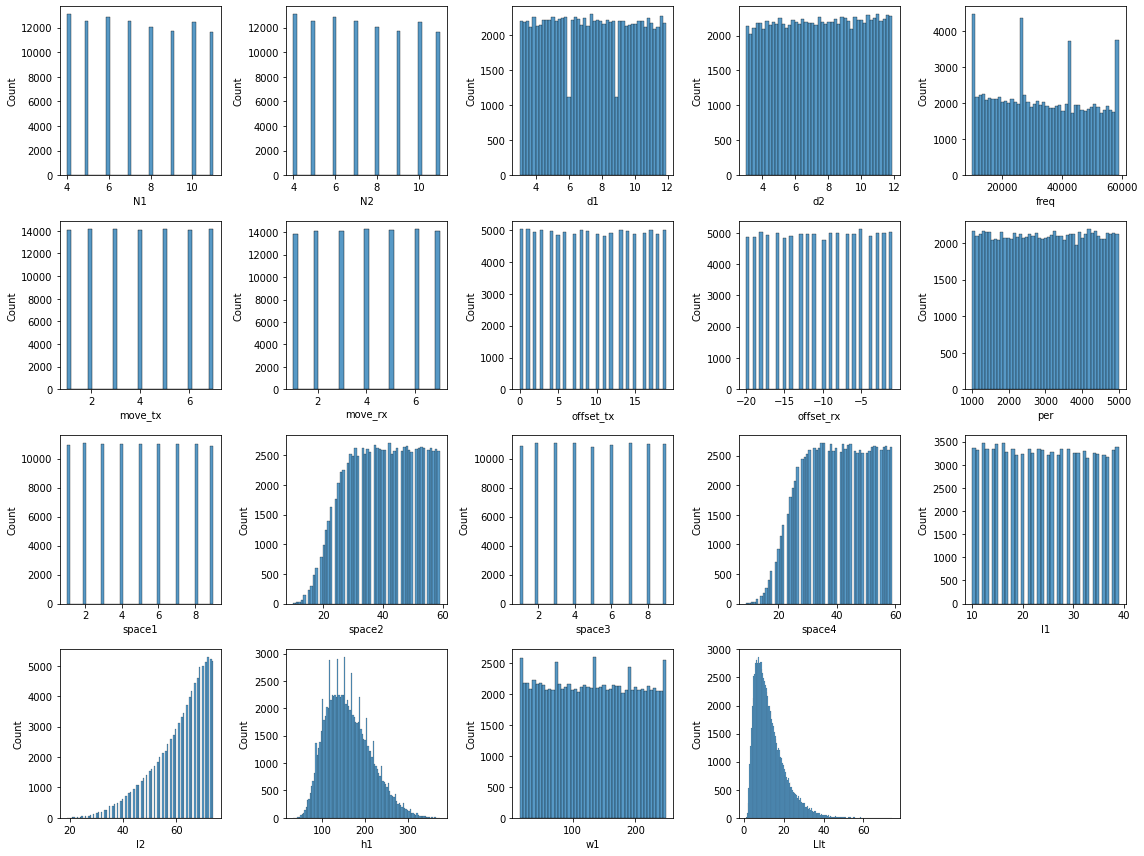

In [90]:
# 5. check data distribution

plt.figure(figsize=(16, 12))
for i, colName in enumerate(list(raw_data.columns)) :
    plt.subplot(4, 5, i+1)
    sns.histplot(raw_data.loc[:, colName])
plt.tight_layout()
plt.show()

<AxesSubplot:>

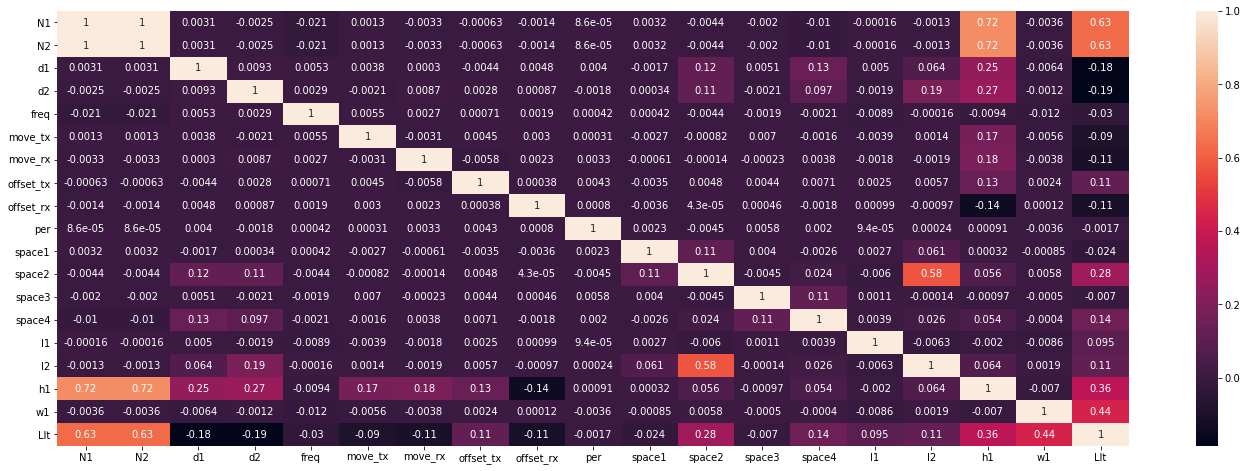

In [91]:
# 6. show corelation between each parameter

plt.figure(figsize=(24, 8))
sns.heatmap(data=raw_data.corr(), annot=True)

In [92]:
# 7. define outlier search function
def get_outlier(df=None, column=None, weight=1.5):
    
    # column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함. 
    data = df[column]
    quantile_25 = np.percentile(data.values, 25)  # 1/4 분위
    quantile_75 = np.percentile(data.values, 75)  # 3/4 분위
    
    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함. 
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight  # 이상치 최소 기준
    highest_val = quantile_75 + iqr_weight # 이상치 최대 기준
    
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환. 
    outlier_index = data[(data < lowest_val) | (data > highest_val)].index
    
    return outlier_index

In [93]:
# 8. data pre-processing

# target 변수 제외
col_input = list(raw_data.columns)[:-1]
print(col_input)

# outlier 탐색 및 제거
outlier_index = {}
for i, colName in enumerate(col_input):
     outlier_index[i] = get_outlier(df=raw_data, column=f'{colName}', weight=1.5)
outlier_index

# 각각의 숫자들 리스트 안에 넣기
outlier_list = []
for i in range(len(outlier_index)):
    if list(outlier_index[i].values) == []:
        continue
    outlier_list.append(list(outlier_index[i].values))

# 리스트 안의 리스트들을 하나로 합치기
outlier_list = sum(outlier_list , [])
print('개수:', len(outlier_list))

# 중복 숫자 제거
outlier_list = set(outlier_list)
print('개수:', len(outlier_list))

# 다시 리스트 타입으로 변환
outlier_list = list(outlier_list)
print(type(outlier_list))

# 리스트 숫자 정렬
outlier_list.sort()

# outlier를 갖는 index에 해당하는 data drop
for i in outlier_list:
    raw_data.drop(i, axis=0, inplace=True)
raw_data.shape

['N1', 'N2', 'd1', 'd2', 'freq', 'move_tx', 'move_rx', 'offset_tx', 'offset_rx', 'per', 'space1', 'space2', 'space3', 'space4', 'l1', 'l2', 'h1', 'w1']
개수: 2200
개수: 2197
<class 'list'>


(96723, 19)

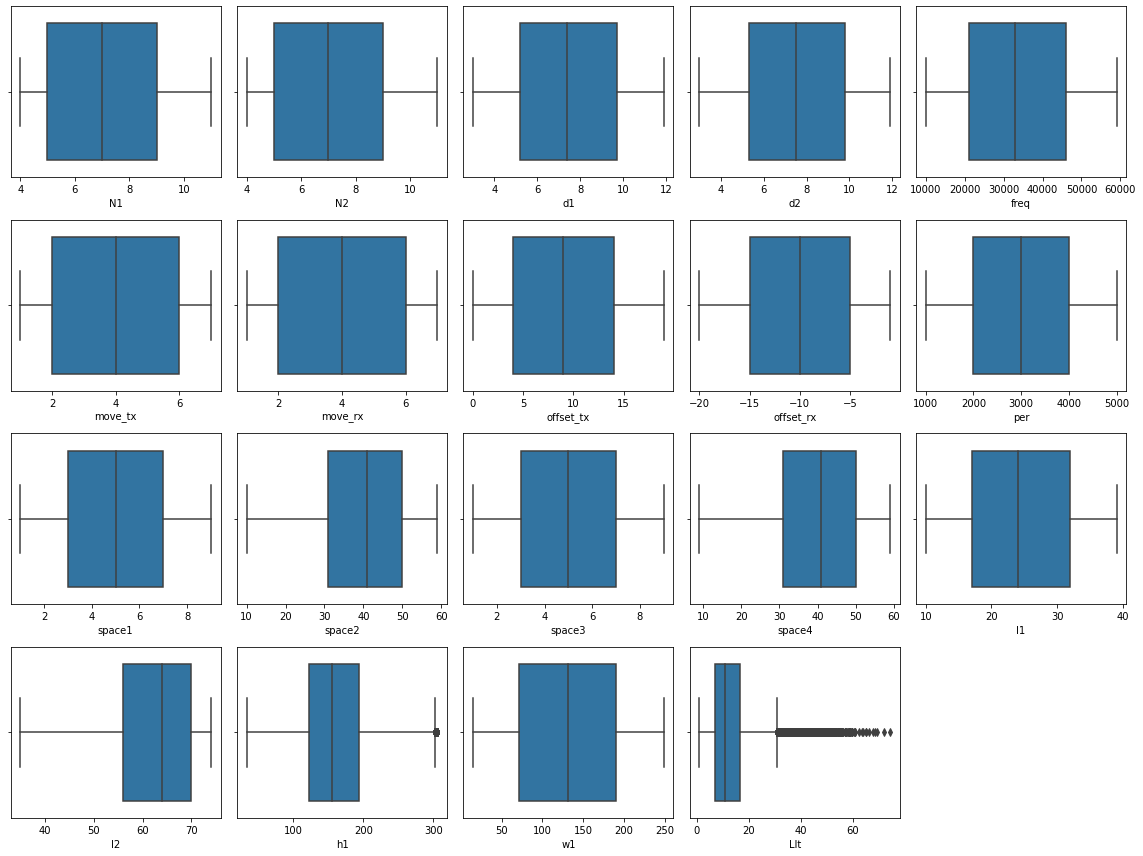

In [94]:
# 9. check outlier (after removing outlier)

plt.figure(figsize=(16, 12))
for i, colName in enumerate(list(raw_data.columns)) :
    plt.subplot(4, 5, i+1)
    sns.boxplot(x=raw_data.loc[:, colName])
plt.tight_layout()
plt.show()

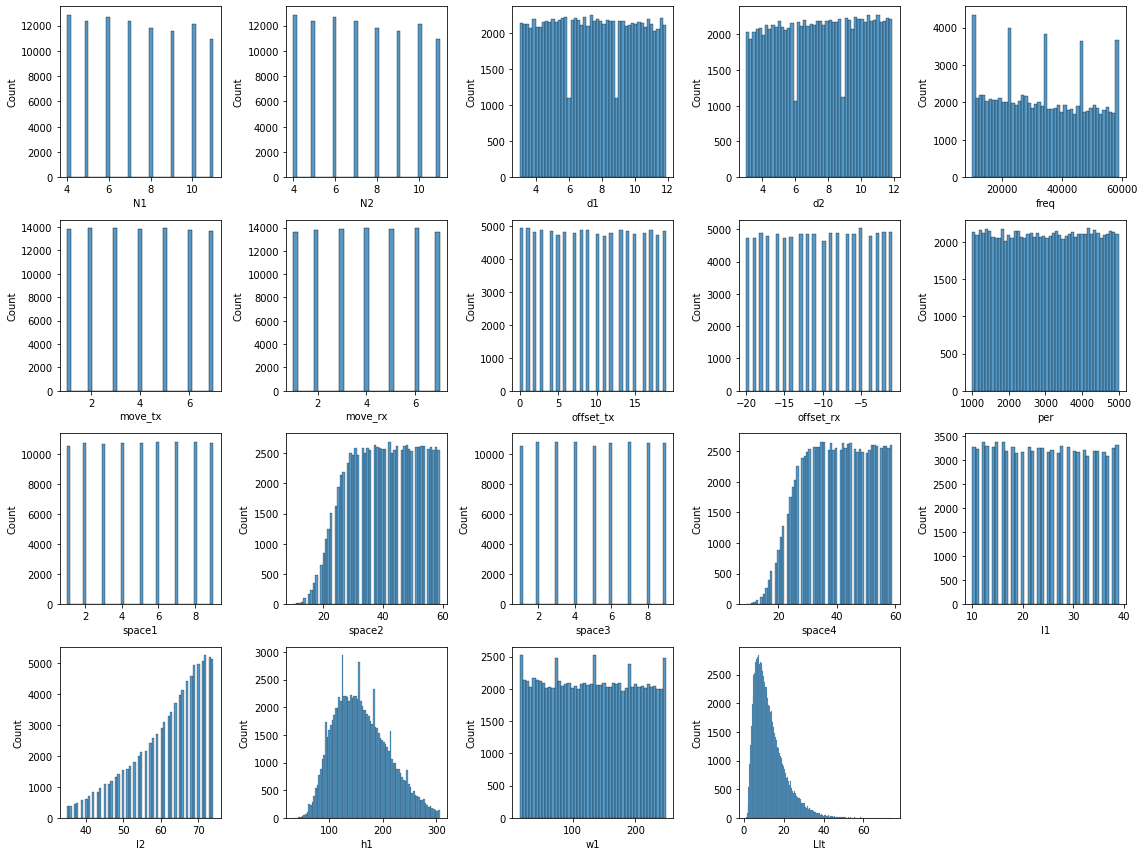

In [95]:
# 10. check data distribution (after pre-processing)
plt.figure(figsize=(16, 12))
for i, colName in enumerate(list(raw_data.columns)) :
    plt.subplot(4, 5, i+1)
    sns.histplot(raw_data.loc[:, colName])
plt.tight_layout()
plt.show()

<AxesSubplot:>

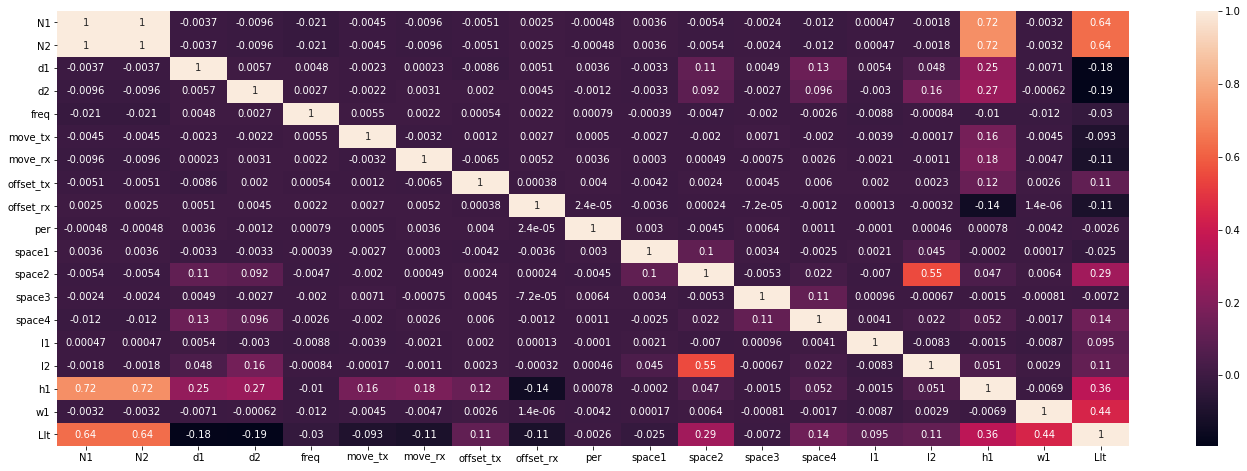

In [96]:
# 11. show corelation between each parameter (after pre-processing)

plt.figure(figsize=(24, 8))
sns.heatmap(data=raw_data.corr(), annot=True)

In [97]:
# 12. split input/output

X = raw_data.drop(columns=parameter)
Y = raw_data[parameter]

raw_data.to_csv("raw_data.csv", mode='w')

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state = 765)


# minmax normalize
scaler = MinMaxScaler()
for colName in col_input:
    X_train[colName] = scaler.fit_transform(X_train[colName].values.reshape(-1, 1))
    X_test[colName] = scaler.fit_transform(X_test[colName].values.reshape(-1, 1))

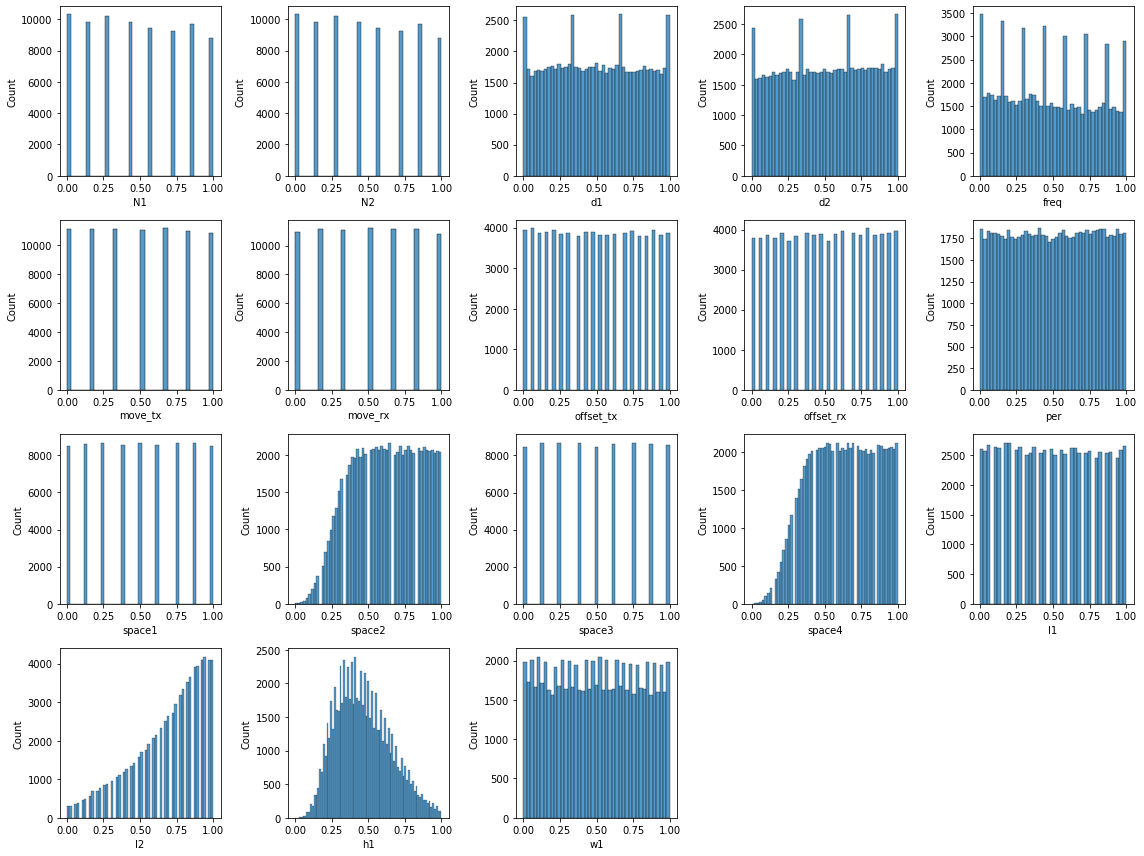

In [98]:
# 13. check data distribution (after normalize)
plt.figure(figsize=(16, 12))
for i, colName in enumerate(list(X_train.columns)) :
    plt.subplot(4, 5, i+1)
    sns.histplot(X_train.loc[:, colName])
plt.tight_layout()
plt.show()

In [99]:
model = LGBMRegressor(random_state=765)
model.fit(X_train,Y_train)

print(model)

LGBMRegressor(random_state=765)


[0.9829959764525469, 0.6861456999910259, 1.045757688971858, 1.0226229456509657, 5.92655295614409, -0.8687608402163064]
[0.9821737330807967, 0.6911499669995389, 1.0845062752100645, 1.041396310349746, 5.82668303641248, -0.6356498174607511]
[0.9820121872033547, 0.686316510638845, 1.0846014160787223, 1.0414419888206554, 5.838411359659303, -0.8729830864311496]
[0.9822725969517849, 0.6961288484350683, 1.0608426969437628, 1.0299721826067745, 5.91642604292784, -0.8436038526710765]
[0.9810607000914534, 0.7067553159394969, 1.1670261054491458, 1.0802898247457233, 5.980470147087767, -0.8013799211657733]


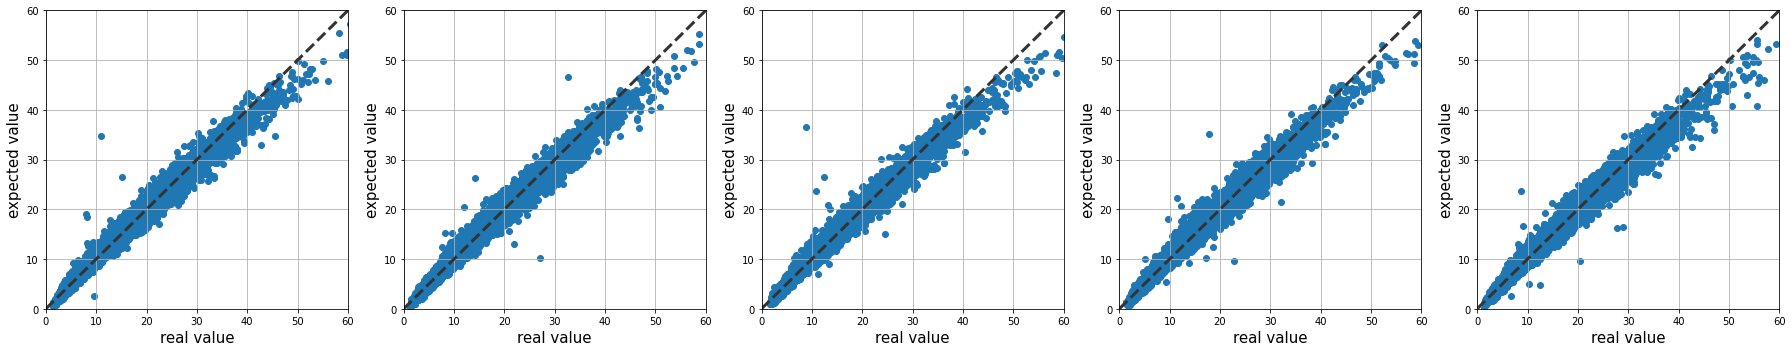

In [144]:
# 교차 검증용 데이터셋 구성
df_trains = []
df_valids = []

# MAPE 정의
def def_MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 

# MPE 정의
def def_MPE(y_test, y_pred): 
	return np.mean((y_test - y_pred) / y_test) * 100

# KFold 검증
i = 0
plt.figure(figsize=(25, 5))
kfold = KFold(n_splits=5, random_state=765, shuffle=True)
for train_idx, test_idx in kfold.split(X[col_input]):

    # fold 후 train, test set 분할
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]

    # regression model 생성
    model.fit(X_train, Y_train)

    # 예측
    fold_pred = model.predict(X_test)

    # 성능계산
    R2 = r2_score(Y_test, fold_pred)
    MAE = mean_absolute_error(Y_test, fold_pred)
    MSE = mean_squared_error(Y_test, fold_pred)
    RMSE = np.sqrt(MSE)
    MAPE = def_MAPE(Y_test, fold_pred)
    MPE = def_MPE(Y_test, fold_pred)

    print([R2, MAE,MSE,RMSE,MAPE,MPE])

    plt.subplot(1, 5, i+1)
    plt.scatter(Y_test, fold_pred)
    plt.xlabel("real value", fontsize=15)
    plt.ylabel("expected value", fontsize=15)
    plt.grid(True)
    plt.xlim(0, 60)
    plt.ylim(0, 60)
    plt.plot([0, 60], [0, 60], ls="--", c=".2", linewidth=3.0)
    i = i+1

plt.tight_layout()
plt.show()

In [187]:
from sklearn.model_selection import GridSearchCV

parameters = {
    "n_estimators" : [1000,3000,10000],
    'n_jobs' : [-1],
    'learning_rate': [0.05],
    'max_depth' : [-1,2,3,4,5,10,20,30,50],
    'num_leaves' : [31,60,80,100,127],
    }

#cv=5 5번의 교차검증.
grid = GridSearchCV(LGBMRegressor(random_state=0), verbose=2, param_grid = parameters, cv=kfold)
grid.fit(X_train, Y_train)

Fitting 5 folds for each of 135 candidates, totalling 675 fits
[CV] learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=31 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=31, total=   1.6s
[CV] learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=31 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=31, total=   1.6s
[CV] learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=31 
[CV]  learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=31, total=   1.9s
[CV] learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=31 
[CV]  learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=31, total=   2.0s
[CV] learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=31 
[CV]  learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=31, total=   1.6s
[CV] learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=60 
[CV]  learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=60, total=   2.9s
[CV] learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=60 
[CV]  learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=60, 

[Parallel(n_jobs=1)]: Done 675 out of 675 | elapsed: 93.1min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=765, shuffle=True),
             estimator=LGBMRegressor(random_state=0),
             param_grid={'learning_rate': [0.05],
                         'max_depth': [-1, 2, 3, 4, 5, 10, 20, 30, 50],
                         'n_estimators': [1000, 3000, 10000], 'n_jobs': [-1],
                         'num_leaves': [31, 60, 80, 100, 127]},
             verbose=2)

In [188]:
grid.best_params_

{'learning_rate': 0.05,
 'max_depth': 4,
 'n_estimators': 10000,
 'n_jobs': -1,
 'num_leaves': 31}

In [189]:
#model = LGBMRegressor(random_state=765, learning_rate=0.05, max_depth=10, n_estimators=5000)
model = LGBMRegressor(random_state=765, **grid.best_params_)
model.fit(X_train,Y_train)

print(model)

LGBMRegressor(learning_rate=0.05, max_depth=4, n_estimators=10000,
              random_state=765)


[0.9967367404379318, 0.2788502349946097, 0.20069242839027002, 0.44798708507084223, 2.5719020184598222, -0.12885265655510975]
[0.9966314787114855, 0.2778493952946852, 0.20493255778849173, 0.45269477331695773, 2.5414847910430605, -0.09800079551282936]
[0.9963715316794853, 0.27737593279693173, 0.21878379117671162, 0.4677432962391996, 2.573770399842457, -0.1414783106899169]
[0.996589848023916, 0.2796818365616523, 0.20407020754578634, 0.45174130599911533, 2.527191982925565, -0.08335625125991666]
[0.9968835615233302, 0.27854007396902053, 0.19203270848773743, 0.4382153676991913, 2.5581818634098474, -0.06755969380986918]


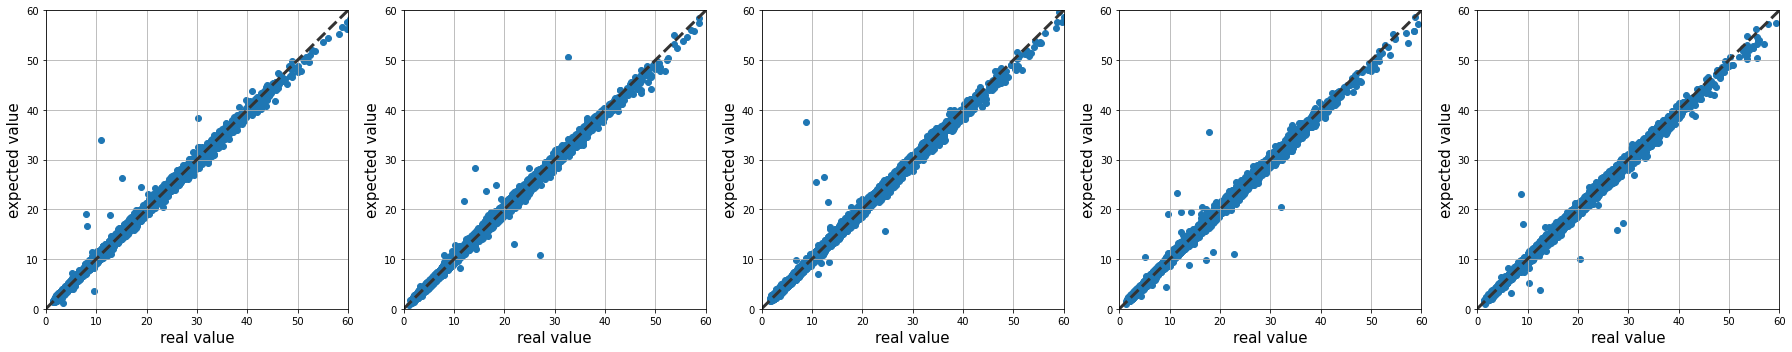

In [190]:
# 교차 검증용 데이터셋 구성
df_trains = []
df_valids = []

# MAPE 정의
def def_MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 

# MPE 정의
def def_MPE(y_test, y_pred): 
	return np.mean((y_test - y_pred) / y_test) * 100

# KFold 검증
i = 0
plt.figure(figsize=(25, 5))
kfold = KFold(n_splits=5, random_state=765, shuffle=True)
for train_idx, test_idx in kfold.split(X[col_input]):

    # fold 후 train, test set 분할
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]

    # regression model 생성
    model.fit(X_train, Y_train)

    # 예측
    fold_pred = model.predict(X_test)

    # 성능계산
    R2 = r2_score(Y_test, fold_pred)
    MAE = mean_absolute_error(Y_test, fold_pred)
    MSE = mean_squared_error(Y_test, fold_pred)
    RMSE = np.sqrt(MSE)
    MAPE = def_MAPE(Y_test, fold_pred)
    MPE = def_MPE(Y_test, fold_pred)

    print([R2, MAE,MSE,RMSE,MAPE,MPE])

    plt.subplot(1, 5, i+1)
    plt.scatter(Y_test, fold_pred)
    plt.xlabel("real value", fontsize=15)
    plt.ylabel("expected value", fontsize=15)
    plt.grid(True)
    plt.xlim(0, 60)
    plt.ylim(0, 60)
    plt.plot([0, 60], [0, 60], ls="--", c=".2", linewidth=3.0)
    i = i+1

plt.tight_layout()
plt.show()